## 練習問題 (A)

### A-1

イテレーションごとに`w`の値が５だけ加算される。

### A-2, A-3

In [1]:
import numpy as np

class Algo_trivial:

    '''
    An iterator which does nothing special at all, but makes
    a trivial update to the initial parameters given, and
    keeps record of the number of iterations made.
    '''

    def __init__(self, w_init, t_max):
        
        self.w = np.copy(w_init)
        self.t_max = t_max


    def __iter__(self):

        self.t = 0
        print("(__iter__): t =", self.t)

        return self
    

    def __next__(self):

        # Condition for stopping.
        
        if self.t >= self.t_max:
            print("--- Condition reached! ---")
            raise StopIteration

        print("(__next__): t =", self.t)
        self.w *= 2
        self.t += 1

        # Note that __next__ does not need to return anything.

    def __str__(self):

        out = "State of w:" + "\n" + "  " + str(self.w)
        return out
    
al = Algo_trivial(w_init=np.array([0, 1, 2, 3, 4]), t_max=4)

for mystep in al:
    print(al) # useful for monitoring state.

(__iter__): t = 0
(__next__): t = 0
State of w:
  [0 2 4 6 8]
(__next__): t = 1
State of w:
  [ 0  4  8 12 16]
(__next__): t = 2
State of w:
  [ 0  8 16 24 32]
(__next__): t = 3
State of w:
  [ 0 16 32 48 64]
--- Condition reached! ---


### A-4

この場合は`w`の値が発散していく。

## 練習問題 (B)

### B-1

座標軸の数は`w`の次元数に依存し、`w`が`d`次元であるなら`d`個座標軸が存在する。

それぞれの座標軸ごとに見るのは定義上`$delta_(w_j)`の微分であるため。

### B-2

ロス関数が偏微分が常に可能であれば`FiniteDiff`を使うことができた。

### B-3

差分法によりある点での$w_{(t)}$に関する微分係数$\nabla l(w_{(t)};z_{i})$を近似している。  
deltaが大きくなるほど精度は荒くなる。

## 練習問題 (C)

In [29]:
import matplotlib
import matplotlib.pyplot as plt

def alpha_fixed(t, val):
    '''
    Step-size function: constant.
    '''
    return val

def alpha_log(t, val=1):
    '''
    Step-size function: logarithmic.
    '''
    return val / (1+math.log((1+t)))

def alpha_pow(t, val=1, pow=0.5):
    '''
    Step-size function: polynomial.
    '''
    return val / (1 + t**pow)


# A function for making step-size functions.
def make_step(u):
    def mystep(t):
        return alpha_fixed(t=t, val=u)
    return mystep

class Algo_GD_FiniteDiff:

    '''
    Iterator which implements a line-search steepest descent method,
    via finite differences to approximate the gradient.
    '''

    def __init__(self, w_init, t_max, step, delta, verbose, store):

        # Store the user-supplied information.
        self.w = np.copy(w_init)
        self.t = None
        self.t_max = t_max
        self.step = step
        self.delmtx = np.eye(self.w.size) * delta
        self.delta = delta
        self.verbose = verbose
        self.store = store
        
        # If asked to store, keep record of all updates.
        if self.store:
            self.wstore = np.zeros((self.w.size,t_max+1), dtype=np.float64)
            self.wstore[:,0] = self.w.flatten()
        else:
            self.wstore = None
        

    def __iter__(self):

        self.t = 0

        if self.verbose:
            print("(via __iter__)")
            self.print_state()
        
        return self

    
    def __next__(self):

        # Condition for stopping.
        if self.t >= self.t_max:
            if self.verbose:
                print("--- Condition reached! ---")
            raise StopIteration

        self.t += 1

        if self.verbose:
            print("(via __next__)")
            self.print_state()


    def update(self, model):
        
        stepsize = self.step(self.t)
        newdir = np.zeros(self.w.size, dtype=self.w.dtype)
        loss = model.l_tr(self.w)

        # Perturb one coordinate at a time, compute finite difference.
        for j in range(self.w.size):
            
            # Perturb one coordinate. MODEL ACCESS here.
            delj = np.take(self.delmtx,[j],axis=1)
            loss_delta = model.l_tr((self.w + delj))
            
            newdir[j] = np.mean(loss_delta-loss) / self.delta
            
            
        self.w = self.w - stepsize * newdir.reshape(self.w.shape)
        
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()


    def print_state(self):
        print("------------")
        print("t =", self.t, "( max = ", self.t_max, ")")
        print("w = ", self.w)
        print("------------")
        
import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

# Data information used to initialize the model.
data_info = dp.NoisyOpt_isoBig()

mod = mp.model(data_info) # pass the data info.


def draw_contour(al, mod):

    mypath = al.wstore

    eval2D = np.vectorize(mod.eval2D_helper)
    tmpdel = np.linalg.norm(mod.w_true-w_init) * 1
    xvals = np.arange(mod.w_true[0]-tmpdel,mod.w_true[0]+tmpdel, 0.1)
    yvals = np.arange(mod.w_true[1]-tmpdel,mod.w_true[1]+tmpdel, 0.1)
    X, Y = np.meshgrid(xvals, yvals)
    Z = eval2D(w1=X, w2=Y)

    myfig = plt.figure(figsize=(6,6))
    ax = myfig.add_subplot(1,1,1)
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*mod.w_true, 'r*', markersize=12) # print true value.
    ax.plot(*mypath[:,-1], 'bo', markersize=6) # print our final estimate.
    plt.title('Trajectory of finite-diff GD routine')
    plt.show()

    perf = mod.eval(al.w)
    print("Error of final point:", perf)

### C-1

初期状態`w_init`をより悪くすると、収束が遅くなる。

初期状態`w_init`をよりよくすると基本的に収束が早くなるが、ステップサイズが大きすぎる場合は解の周辺で振動することになる。

### C-2

（別のノートブックのをコピー）

### C-3

### C-4

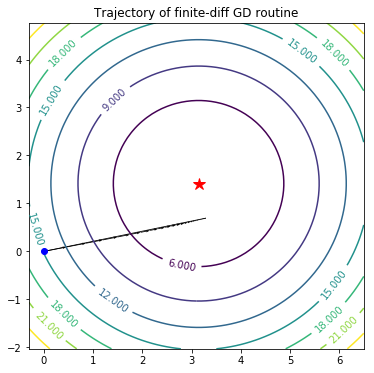

Error of final point: 3.54149067205


In [18]:
class Algo_GD_FiniteDiff_Thres(Algo_GD_FiniteDiff):


    def __init__(self, w_init, t_max, step, thres, delta, verbose, store):

        super().__init__(w_init, t_max, step, delta, verbose, store)
        
        # thres変数の追加
        self.thres = thres
        self.thres_reached = False
    
    def __next__(self):

        # Condition for stopping.
        if self.t >= self.t_max or self.thres_reached:
            if self.verbose:
                print("--- Condition reached! ---")
            raise StopIteration

        self.t += 1

        if self.verbose:
            print("(via __next__)")
            self.print_state()


    def update(self, model):
        
        stepsize = self.step(self.t)
        newdir = np.zeros(self.w.size, dtype=self.w.dtype)
        loss = model.l_tr(self.w)

        # Perturb one coordinate at a time, compute finite difference.
        for j in range(self.w.size):
            
            # Perturb one coordinate. MODEL ACCESS here.
            delj = np.take(self.delmtx,[j],axis=1)
            loss_delta = model.l_tr((self.w + delj))
            
            newdir[j] = np.mean(loss_delta-loss) / self.delta
            
            
        self.w = self.w - stepsize * newdir.reshape(self.w.shape)
        
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()
            
        # normの計算
        if np.linalg.norm(stepsize * newdir) < self.thres:
            self.thres_reached = True

w_init = np.array([0,0], dtype=np.float64).reshape((2,1))

# Initialize the algorithm object.
al = Algo_GD_FiniteDiff_Thres(w_init=w_init,
                        delta=0.01,
                        step=make_step(0.1),
                        thres=0.01,
                        t_max=1000,
                        verbose=False,
                        store=True)

for mystep in al:
    al.update(model=mod)
    
draw_contour(al, mod)

### C-5

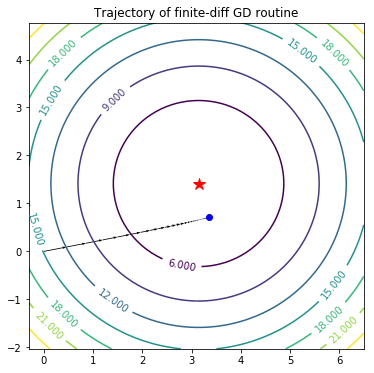

Error of final point: 3.53625536657


In [19]:
class Algo_GD_FiniteDiff_Reverse(Algo_GD_FiniteDiff):

    def update(self, model):
        
        stepsize = self.step(self.t)
        newdir = np.zeros(self.w.size, dtype=self.w.dtype)
        loss = model.l_tr(self.w)

        # Perturb one coordinate at a time, compute finite difference.
        for j in range(self.w.size):
            
            # Perturb one coordinate. MODEL ACCESS here.
            delj = np.take(self.delmtx,[j],axis=1)
            loss_delta = model.l_tr((self.w + delj))
            
            '''
            先に平均を求めてから偏微分の近似を行う
            '''
            newdir[j] = (np.mean(loss_delta)-np.mean(loss)) / self.delta
            
        self.w = self.w - stepsize * newdir.reshape(self.w.shape)
        
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()

# Initialize the algorithm object.
al = Algo_GD_FiniteDiff_Reverse(w_init=w_init,
                        delta=0.01,
                        step=make_step(0.1),
                        t_max=1000,
                        verbose=False,
                        store=True)

for mystep in al:
    al.update(model=mod)
    
draw_contour(al, mod)

性能に変化があるもののどちらがいいとは言えない。

### C-6

ガウス分布の場合、分散が大きいほど収束しづらくなる。

## 練習問題 (D)

### D-1

`n`を大きくしてもあまり変化は見られなかったが`n`を小さくすると結果が安定しなくなった。

これは、`n`の初期値`50`、つまりサンプル数が`50`程度あればノイズがある程度平均化され安定した結果が得られるが、サンプル数が少ないとばらつきが多くなるため結果が安定しないと考えられる。

### D-2

Error: 3.23219294139
Error: 3.32144092357
Error: 4.08943064762
Error: 3.96434838204
Error: 3.40843591025
Error: 3.02638019496
Error: 3.21694606241
Error: 5.06899772536
Mean of perf = 3.66602159845
Std of perf =  0.634499763542


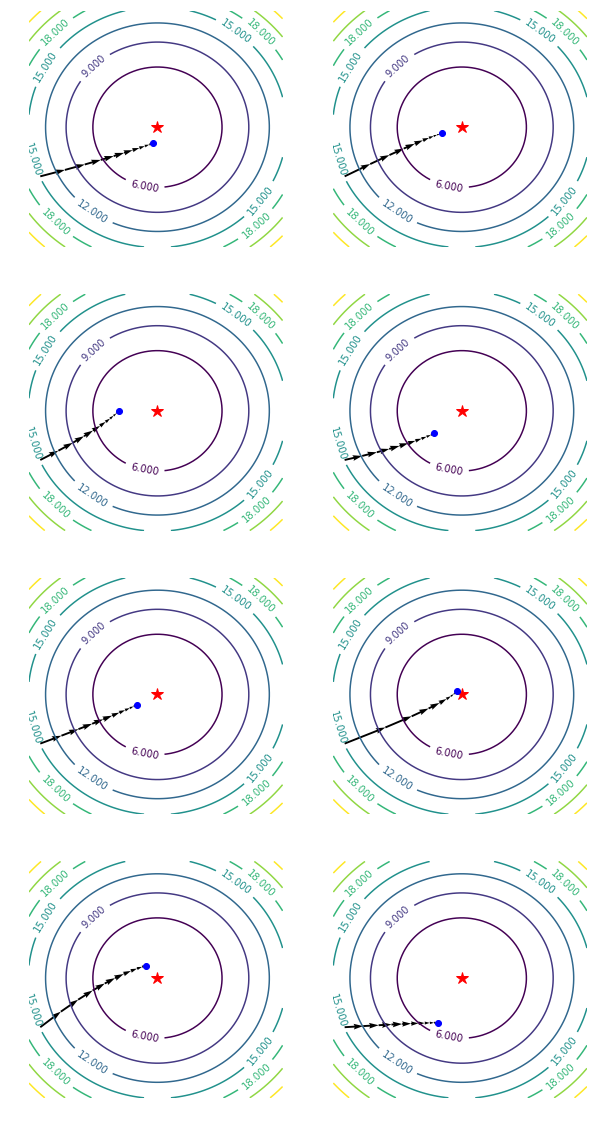

In [27]:

import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

w_init = np.array([0,0], dtype=np.float64).reshape((2,1))

num_trials = 8

w_est_overtrials = {str(i):None for i in range(num_trials)} # initialize

perf_list = []

for tr in range(num_trials):
    
    # Generate new data.
    data_info = dp.NoisyOpt_isoBig()
    mod = mp.model(data_info)
    
    # "Run" the algorithm.
    al = Algo_GD_FiniteDiff(w_init=w_init,\
                            delta=0.01,\
                            step=make_step(0.2),\
                            t_max=10,\
                            verbose=False,\
                            store=True)
    for mystep in al:
        al.update(model=mod)
    
    perf = mod.eval(al.w)
    print("Error:", perf)
    
    '''
        リストに追加
    '''
    perf_list.append(perf)
    
    # Store the algorithm's output (the full trajectory).
    w_est_overtrials[str(tr)] = al.wstore

'''
平均と標準偏差を表示
'''
perf_list = np.array(perf_list)
print('Mean of perf =', perf_list.mean())
print('Std of perf = ', perf_list.std())

eval2D = np.vectorize(mod.eval2D_helper)
tmpdel = np.linalg.norm(mod.w_true-w_init) * 1
xvals = np.arange(mod.w_true[0]-tmpdel,mod.w_true[0]+tmpdel, 0.1)
yvals = np.arange(mod.w_true[1]-tmpdel,mod.w_true[1]+tmpdel, 0.1)
X, Y = np.meshgrid(xvals, yvals)
Z = eval2D(w1=X, w2=Y)
    
myfig = plt.figure(figsize=(10,20))

grididx = 1
for tr in range(num_trials):
    
    mypath = w_est_overtrials[str(tr)]
    
    ax = myfig.add_subplot(num_trials//2, 2, grididx)
    grididx += 1
    
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*mod.w_true, 'r*', markersize=12)
    ax.plot(*mypath[:,-1], 'bo', markersize=6)
    ax.axis("off")

plt.show()

### D-3

`forward difference`と`backward difference`は性能面で大きな差はないが、`central difference`は両側に対して差分を取るため、より実際の微分係数に近づき性能が向上する。

## 練習問題 (E)

In [28]:
class Algo_GD(Algo_GD_FiniteDiff):

    '''
    Iterator which implements a line-search steepest descent method,
    using the sample mean estimate of the gradient.
    '''

    def __init__(self, w_init, t_max, step, verbose, store):
        
        super(Algo_GD,self).__init__(w_init=w_init, t_max=t_max, step=step,
                                     delta=0, verbose=verbose, store=store)


    def update(self, model):
        
        stepsize = self.step(self.t)
        
        # Instead of finite-difference approximation, simply
        # access the gradient method of our model object.
        newdir = np.mean(model.g_tr(w=self.w),
                         axis=0) # take sample mean to get update direction.
        
        self.w = self.w - stepsize * newdir.reshape(self.w.shape)
        
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()

### E-1

Error: 3.39054828418
Error: 3.29376507829
Error: 4.15116962465
Error: 3.79588474503
Error: 3.79415923368
Error: 3.70514437057
Error: 3.46298778902
Error: 3.15712348091
Mean of perf = 3.59384782579
Std of perf =  0.304789055502


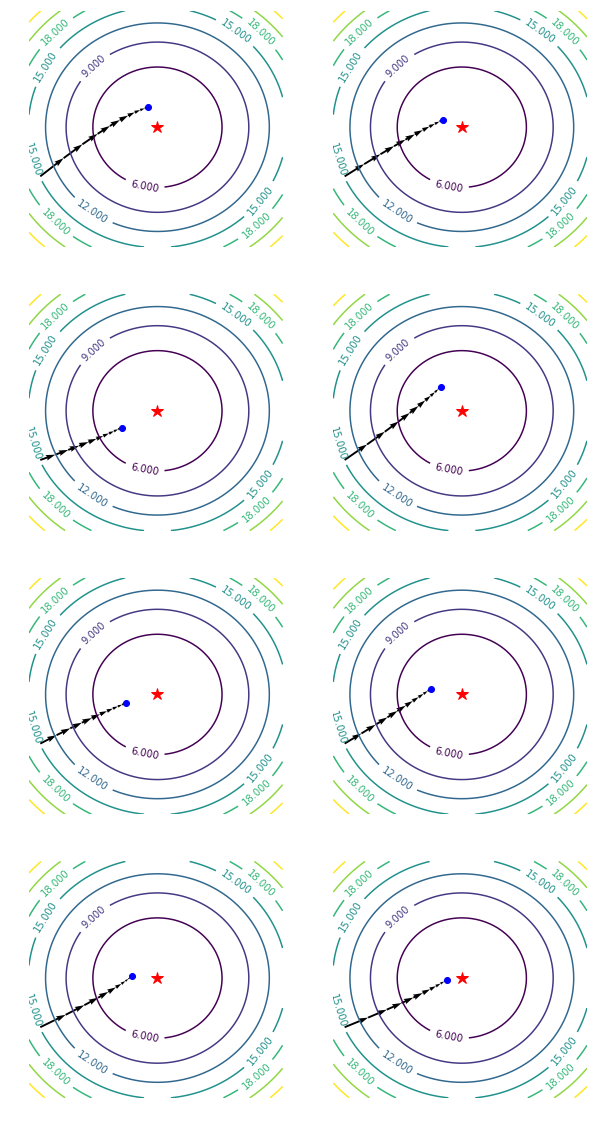

In [26]:
import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

# w_init = np.array([0,0], dtype=np.float64).reshape((2,1))

num_trials = 8

w_est_overtrials = {str(i):None for i in range(num_trials)} # initialize

perf_list = []

for tr in range(num_trials):
    
    # Generate new data.
    data_info = dp.NoisyOpt_isoBig()
    mod = mp.model(data_info)
    
    # "Run" the algorithm.
    al = Algo_GD(w_init=w_init,\
                 step=make_step(0.2),\
                 t_max=10,\
                 verbose=False,\
                 store=True)
    for mystep in al:
        al.update(model=mod)
        
    perf = mod.eval(al.w)
    print("Error:", perf)

    perf_list.append(perf)

    # Store the algorithm's output (the full trajectory).
    w_est_overtrials[str(tr)] = al.wstore

'''
平均と標準偏差を表示
'''
perf_list = np.array(perf_list)
print('Mean of perf =', perf_list.mean())
print('Std of perf = ', perf_list.std())    

eval2D = np.vectorize(mod.eval2D_helper)
tmpdel = np.linalg.norm(mod.w_true-w_init) * 1
xvals = np.arange(mod.w_true[0]-tmpdel,mod.w_true[0]+tmpdel, 0.1)
yvals = np.arange(mod.w_true[1]-tmpdel,mod.w_true[1]+tmpdel, 0.1)
X, Y = np.meshgrid(xvals, yvals)
Z = eval2D(w1=X, w2=Y)
    
myfig = plt.figure(figsize=(10,20))

grididx = 1
for tr in range(num_trials):
    
    mypath = w_est_overtrials[str(tr)]
    
    ax = myfig.add_subplot(num_trials//2, 2, grididx)
    grididx += 1
    
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*mod.w_true, 'r*', markersize=12)
    ax.plot(*mypath[:,-1], 'bo', markersize=6)
    ax.axis("off")

plt.show()

### E-2

偏微分を直接した場合の方が平均・分散ともに小さくなる。

## 練習問題 (F)

### F-2

`t_max`を大きくし、ステップサイズを小さくすると奇跡が安定し、解へ収束していく。

### F-3

#### step: 0.2, t_max: 10

* SGD mean: 5.25452661914, std: 2.84676440632
* GD mean: 3.37704518777, std: 0.135725082329

#### step: 0.01, t_max: 300

* SGD mean: 3.35099706302, std: 0.227244501867
* GD mean: 3.48289391789, std: 0.361731990655

ステップが大きく反復回数が小さいと平均・分散共にSGDの方が大きくなるが、 ステップを小さく反復回数が大きいとSGDの方が成績が良くなる